# The Two Crystal Balls Problem
## Problem Statement
You have two identical crystal balls and a building with "n" floors. One of the floors in the building is the highest floor from which a ball can be dropped without breaking. You need to determine this floor using the fewest possible drops.

## Rules
	• If a ball is dropped from a floor higher than the breaking point, it will break.
	• If a ball is dropped from a floor lower than or equal to the breaking point, it will not break.

### Generating the problem
We can simplify this problem as just a List, with all positions set to False up to a Threshold point. Past this point, all positions are True. Each list position represents a "building floor".

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import logging
import matplotlib.pyplot as plt

In [2]:
# Initialize logging
logging.basicConfig(level=logging.CRITICAL)  # Change the level to control verbosity

In [3]:
def genBuilding(maxFloors = 100):
    threshold = np.random.randint(0, maxFloors + 1) #random position

    # populating False values
    building = [False] * maxFloors 

    # populating True values
    for i in range(threshold, maxFloors): 
        building[i] = True

    logging.info(f"Threshold Value:{threshold}")
    return building

### Solving the problem naively
What would be the simplest (and most inefficient) way of solving this problem? Doing a Linear Search. This doesn't take advantage that we have TWO balls to work with, and it's not that fast, it's O(N). We can do much better than that.

We could use an algorithm similar to Binary Search.
Sadly it has a flaw in it. Let's imagine the worst-case scenario:
We throw our first ball from the mid-point, but we got unlucky and it unfortunately breaks in the first try. How could we proceed safely from this point on? We HAVE to search linearly.
So worst-case is: O(2/N). For a big enough N, that's essentially still O(N).

Again, it's not the best, but it gives us a base line to work with.

In [4]:
def bSearch(building):
    lowValue = 0
    highValue = len(building) - 1
    counter = 0
    
    while lowValue <= highValue:
        mid = lowValue + (highValue - lowValue) // 2
        logging.debug("mid: %s", mid)
        counter += 1
        
        if building[mid]:
            logging.info(f'Oooh no, we exploded the first crystal at the {mid}th floor')            
            highValue = mid
            
            #standard Linear Search
            for j in range(lowValue, highValue, 1):
                counter += 1             
                if building[j]:
                    logging.info(f"The ball survived up to the {j-1}th floor")
                    return (counter)                

            logging.warning("This building does not look to be built correctly")
            break

        elif lowValue >= highValue:
            logging.error("I don't think this ball is breakable with this building")
            break

        logging.debug(f"Ball didn't break from {mid}th floor!")
        lowValue = mid + 1

    logging.info("We ended experiments.")

In [5]:
print("We needed this amount of iterations:",
      bSearch(genBuilding(100)))

We needed this amount of iterations: 47


### A better solution
What if we wanted a sub O(N) solution? Like a O(logN) algorithm. We can achieve that by using the power of square root.
Instead of dividing the floors in half each time, we can test increments of size sqrt(N), and when the first ball breaks, we do a linear search on the remainder.

#### Worst-case Scenario
What if the ball breaks at the very last floor? (Or at least very close to it) In a 100 story building, we'd have to test 10 times, break the first ball, then do up to 10 iterations to learn that only the last floor breaks the balls. That's equivalent to 10 + 10 iterations, or sqrt(100) + sqrt(100) or 2 * sqrt(100).

For very large buildings, that will be a markedly better algorithm than the bSearch we've done, scaling on O(logN) [since we can ignore the constant '2', on very large N]

In [6]:
def logSearch(building):
    stepSize = int(np.sqrt(len(building)))
    highValue = len(building) - 1
    counter = 0
    
    for i in range(1,stepSize):
        counter += 1
        if building[stepSize*i]:
            logging.info(f'Oooh no, we exploded the first crystal at the {stepSize*i}th floor')   
            lastSpot = stepSize*(i-1)
            
            # Standard Linear Search
            for j in range(lastSpot, highValue, 1):
                counter += 1
                if building[j]:
                    logging.info(f"The ball survived up to the {j-1}th floor")
                    return (counter)
            logging.warning("This building does not look to be built correctly")
            break
            
        logging.debug(f"Ball didn't break from {stepSize*i}th floor!")
    logging.info("We ended experiments.")

In [7]:
print("We needed this amount of iterations:",
      logSearch(genBuilding(100)))

We needed this amount of iterations: 16


## Let's crunch some numbers
Let's observe how both algorithms behave with buildings of vastly different scales.
We'll plot how many iterations it takes for each algorithm to solve this problem at different N.

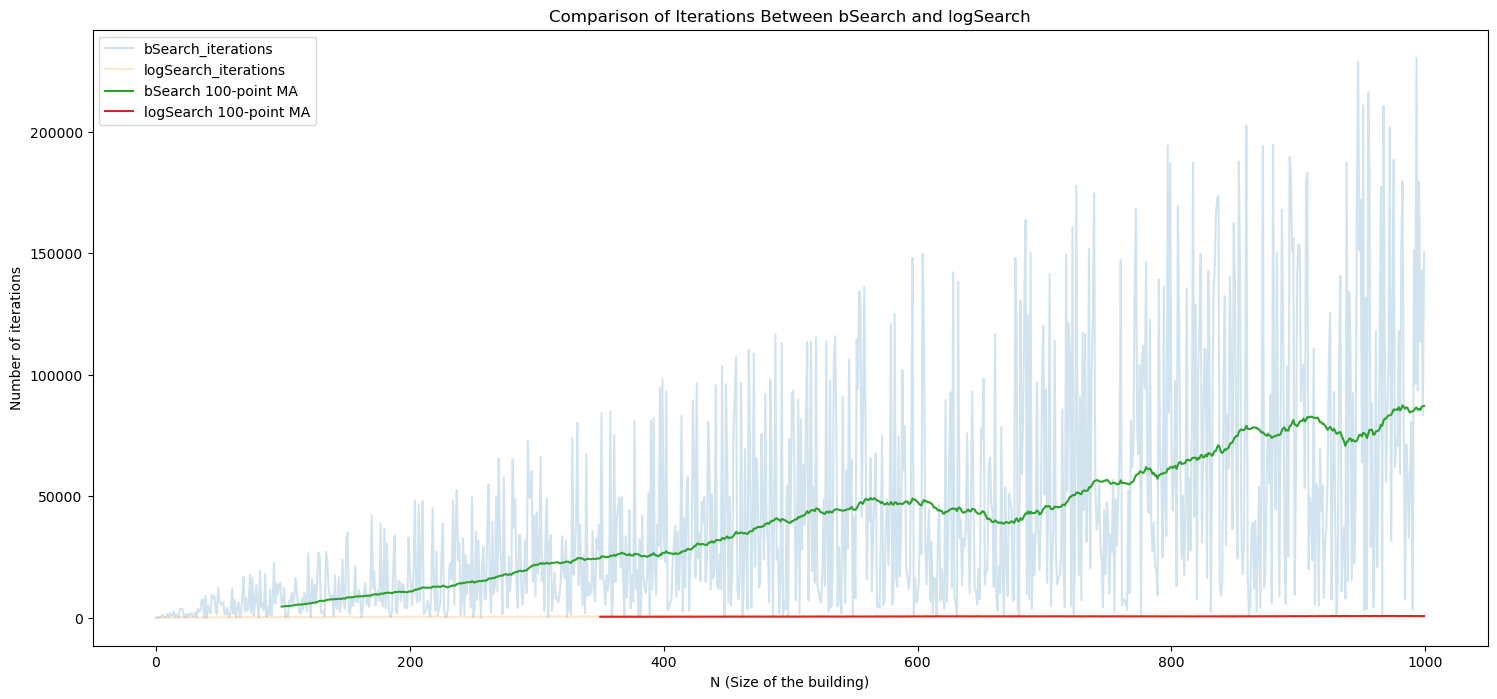

In [18]:
def plot_iterations(bSearch_iterations, logSearch_iterations, window_size=100):
    df = pd.DataFrame({
        'N': np.arange(len(bSearch_iterations)),
        'bSearch_iterations': bSearch_iterations,
        'logSearch_iterations': logSearch_iterations
    })

    # Compute moving averages
    df['bSearch_moving_avg'] = df['bSearch_iterations'].rolling(window=window_size).mean()
    df['logSearch_moving_avg'] = df['logSearch_iterations'].rolling(window=window_size).mean()

    # Create the plots
    plt.figure(figsize=(18, 8))
    sns.lineplot(x='N', y='bSearch_iterations', data=df, label='bSearch_iterations', alpha = 0.2)
    sns.lineplot(x='N', y='logSearch_iterations', data=df, label='logSearch_iterations', alpha = 0.2)

    # Add moving averages to the plot
    sns.lineplot(x='N', y='bSearch_moving_avg', data=df, label=f'bSearch {window_size}-point MA')
    sns.lineplot(x='N', y='logSearch_moving_avg', data=df, label=f'logSearch {window_size}-point MA')
    
    plt.legend()
    plt.xlabel("N (Size of the building)")
    plt.ylabel("Number of iterations")
    plt.title("Comparison of Iterations Between bSearch and logSearch")
    plt.show()

# Generate data
bSearch_iterations = []
logSearch_iterations = []
N_values = np.arange(150, 500000, 500)

for N in N_values:
    building = genBuilding(maxFloors=N)
    bSearch_iterations.append(bSearch(building))
    logSearch_iterations.append(logSearch(building))

# plot_iterations(bSearch_iterations, logSearch_iterations, 100) # To avoid commit pollution, I'm displaying the chart as an image, below:

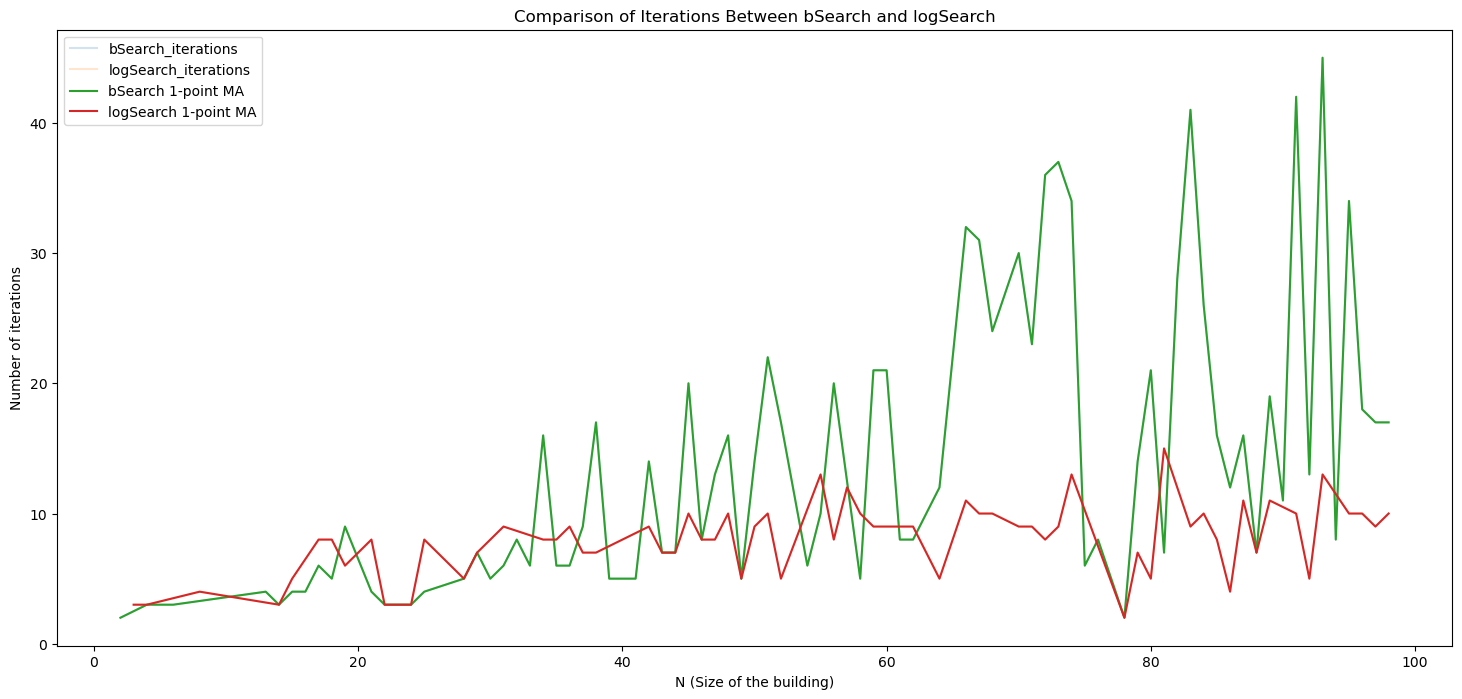

In [16]:
# Generate data
bSearch_iterations = []
logSearch_iterations = []
N_values = np.arange(1, 100, 1)

for N in N_values:
    building = genBuilding(maxFloors=N)
    bSearch_iterations.append(bSearch(building))
    logSearch_iterations.append(logSearch(building))

# plot_iterations(bSearch_iterations, logSearch_iterations, 1) # To avoid commit pollution, I'm displaying the chart as an image, below:

![alt text](https://i.imgur.com/ZyL8xWN.png "Title")

As you can see, for big buildings, logSearch is much better than bSearch.

For small buildings, in some instances bSearch can be marginally better.